In [147]:
# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt


# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from mne_bids import BIDSPath
from mne import EpochsArray
from mne.viz import plot_compare_evokeds
from copy import deepcopy
import mne
from statsmodels.formula.api import mixedlm


from scipy.stats import ttest_ind


# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


# import summary_df from csv file
summary_df = pd.read_csv("global_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore_nocrop.csv")
stats_df = pd.read_csv("individual_mean_stddev_zscore_negcorr.csv")



# Preprocessing

In [148]:

def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()

    
    
    # Remove break annotations
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    
    
    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    
    # get the total number of short channels
    short_chs = get_short_channels(raw_od)
    tot_number_of_short_channels = len(short_chs.ch_names)
    

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.7, h_freq=1.45)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.8))
    
    if len(bad_channels) > 55:
        print(f"❌ Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None, None, None, None, None
    
    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels
 
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)

    
     # Get long channels
    long_chs = get_long_channels(raw_od)
    bad_long_chs = long_chs.info["bads"]
    
    len_bad_short_chs = len(bad_channels) - len(bad_long_chs)
    num_good_short_channels = tot_number_of_short_channels - len_bad_short_chs

    # Determine if there are short channels
    if num_good_short_channels < 4:
        print("❌ No short channels found. Skipping the subject.")
        return None, None, None, None, None # Keep the data unchanged
    else:
        raw_od_corrected = short_channel_regression(raw_od)
        
    
    # Convert to haemoglobin and filter    
        
    raw_haemo = beer_lambert_law(raw_od_corrected, ppf=0.1)
    
    raw_haemo = get_long_channels(raw_haemo, min_dist=0.02) 
    
    # negative correlation enhancement
    raw_haemo = enhance_negative_correlation(raw_haemo)
    
           
    raw_haemo = raw_haemo.filter(l_freq = None, h_freq = 0.2,  
                                 method="iir", iir_params =dict(order=5, ftype='butter'))
    raw_haemo= raw_haemo.filter(l_freq =  0.05, h_freq = None, method="iir", iir_params =dict(order=5, ftype='butter')) #t0.05 was cutoff in andreas analysis
      
    # Create events and epochs
    events, event_dict = events_from_annotations(
        raw_haemo, verbose=False, regexp="^(?![Ends]).*$"
    )
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=-3,
        tmax=14,
        reject=dict(hbo=100e-6),
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=None,
    )

    return raw_haemo, epochs, event_dict, raw_od, events

# Epoch Rejection

## Individual Level-zscore

In [3]:
def reject_epochs_zscore_individual(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0):
    """
    Rejects epochs based on z-score threshold using subject/session/condition-specific stats from stats_df.

    Parameters:
        data (ndarray): (n_epochs, n_times) or (n_epochs,) averaged data per epoch
        subject (str): e.g., "sub-01"
        session (str): e.g., "ses-01"
        condition_name (str): "Control", "Noise", or "Speech"
        stats_df (pd.DataFrame): DataFrame with per-participant mean and std
        z_thresh (float): Z-score threshold
        max_reject_ratio (float): Max proportion of epochs to reject

    Returns:
        cleaned_data (ndarray), rejected_indices (list)
    """
    row = stats_df[
        (stats_df["Subject"] == f"sub-{subject}") &
        (stats_df["Session"] == f"ses-{session}") &
        (stats_df["Condition"] == condition_name)
    ]

    if row.empty:
        raise ValueError(f"No stats found for {subject}, {session}, {condition_name}")

    mean = row["Mean_Amplitude"].values[0]
    std = row["SD_Amplitude"].values[0]

    z_scores = (data - mean) / std
    reject_mask = np.abs(z_scores) > z_thresh
    rejected_indices = np.where(reject_mask)[0].tolist()

    # Limit rejections
    max_reject = int(max_reject_ratio * data.shape[0])
    if len(rejected_indices) > max_reject:
        rejected_indices = rejected_indices[:max_reject]

    cleaned_data = np.delete(data, rejected_indices, axis=0)
    return cleaned_data, rejected_indices


# Full preprocessing function

In [149]:
def full_preprocessing_individual(bids_path, z_thresh=2, stats_df=None):
    
    raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)

    if raw_haemo is None or epochs is None or len(epochs) < 10:
        print(f"⚠️ Skipping {bids_path.basename} (insufficient or failed data)")
        return None

    sub = bids_path.subject
    ses = bids_path.session

    # Drop bad channels, pick HbO only, and crop
    epochs.drop_channels(epochs.info['bads'])
    epochs_cleaned = epochs.copy().pick("hbo")
    #epochs_cleaned.crop(tmin=0.0, tmax=10.0)

    # Prepare data for rejection
    #data = epochs_cleaned.get_data(tmin=0.0, tmax=10.0).mean(axis=1)
    data = epochs_cleaned.get_data().mean(axis=1)
    data_mean = data.mean(axis=1)
    ev = epochs_cleaned.events[:, 2]
    labels = np.hstack((np.arange(len(ev)).reshape(-1, 1), ev.reshape(-1, 1)))

    conditions = {1: "Control", 2: "Noise", 3: "Speech"}
    all_rejected = []

    for cond_code, cond_name in conditions.items():
        cond_idx = labels[labels[:, 1] == cond_code][:, 0].astype(int)
        cond_data = data_mean[cond_idx]

        try:
            cleaned, rejected = reject_epochs_zscore_individual(
                cond_data,
                subject=sub,
                session=ses,
                condition_name=cond_name,
                stats_df=stats_df,
                z_thresh=z_thresh
            )
        except ValueError as e:
            print(f"⚠️ {e}")
            continue

        rejected_indices = [cond_idx[i] for i in rejected]
        all_rejected.extend(rejected_indices)
        print(f"Subject {sub}, Session {ses} - Rejected {len(rejected)} epochs in {cond_name}")

    # Drop bad epochs
    epochs_cleaned.drop(all_rejected)

    return epochs_cleaned, event_dict


# WAA Data-driven ROIs Construction
Single Optode Significance Analysis

In [11]:
def run_lme_per_session(data, session_label):
    subset_session = data[(data["Chroma"] == "hbo") & (data["Session"] == session_label)]
    optodes = subset_session["Optode"].unique()

    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["ID"].nunique() < 2:
            print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("Value ~ Condition", subset, groups=subset["Subject"])
            result = model.fit(method="nm")

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["ID"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt} (Session {session_label}): {e}")

    return pd.DataFrame(results_summary)

In [75]:
def run_lme_both_ses(data):
    subset_session = data[(data["Chroma"] == "hbo") ]
    optodes = subset_session["Optode"].unique()

    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["ID"].nunique() < 2:
            #print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("Value ~ Condition", subset, groups=subset["ID"])
            result = model.fit(method="nm")

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["ID"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt}: {e}")

    return pd.DataFrame(results_summary)

In [245]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

        # Construction of WAA Data-driven ROIS --> Single Optode Significance Testing
        optode_rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }
        
        df = pd.DataFrame(columns=["ID", "Subject", "Session", "Optode", "Chroma", "Condition", "Value"])

        id=id+1 
        
        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()

            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in optode_rois.items():
                # Keep only optodes that exist in this subject/session
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                
                if not valid_optodes:
                    #print(f"⚠️ Optode'{roi_name}' marked as bad in Subject {sub}. Skipping this Optode.")
                    continue  # Skip if no optodes available

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=4.25, tmax=6.75).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "Optode": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
                        
                    

                    except Exception as e:
                        print(f"❌ Failed to process Optode '{roi_name}' with error: {e}")
                    
        all_data = pd.concat([all_data, df], ignore_index=True)
# save all_data to csv
all_data.to_csv("all_subjects_evoked_values_optodes.csv", index=False)

Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

In [248]:
# Run LME for each session
results_ses01_df = run_lme_per_session(all_data, "01")
results_ses02_df = run_lme_per_session(all_data, "02")


c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: T

In [249]:
results_both_ses= run_lme_both_ses(all_data)

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: T

In [250]:
def get_significant_optodes_by_condition(df):
    speech_sig = df[df["PValue_Condition[T.Speech]"] < 0.05].copy()
    speech_sig = speech_sig.drop(["Coef_Condition[T.Noise]", "PValue_Condition[T.Noise]", "N_Subjects", 'N_Trials'], axis=1)

    noise_sig = df[df["PValue_Condition[T.Noise]"] < 0.05].copy()
    noise_sig = noise_sig.drop(["Coef_Condition[T.Speech]", "PValue_Condition[T.Speech]", "N_Subjects", 'N_Trials'], axis=1)
    if speech_sig.empty:
        print("No significant optodes.")
    if noise_sig.empty:
        print("No significant optodes.")
    return speech_sig, noise_sig


In [251]:
speech_sig_ses01, noise_sig_ses01 = get_significant_optodes_by_condition(results_ses01_df)
speech_sig_ses02, noise_sig_ses02 = get_significant_optodes_by_condition(results_ses02_df)
speech_sig_both_ses, noise_sig_both_ses = get_significant_optodes_by_condition(results_both_ses)

## FDR correction

In [256]:
m= 50 # number of independent tests (number of optodes x 2 conditions- control vs noise, control vs speech)
q=0.05
# get the p-values for noise both sessions
p_values = noise_sig_both_ses["PValue_Condition[T.Noise]"].values
# sort the p-values
sorted_p_values = np.sort(p_values)
for i in range(0, len(sorted_p_values)):  
    p_val = sorted_p_values[i]     
    threshold= (q*(i+1))/m
    
    # pass if p-value <= threshold
    if p_val <= threshold:
        print(f"Optode {noise_sig_both_ses.iloc[i]['Optode']} is significant with p-value {p_val} and threshold {threshold}")
    else:
        print(f"Optode {noise_sig_both_ses.iloc[i]['Optode']} is not significant with p-value {p_val} and threshold {threshold}")
        


Optode S4_D2 is significant with p-value 0.0001319956321670259 and threshold 0.001
Optode S5_D2 is significant with p-value 0.0006532252912925388 and threshold 0.002
Optode S5_D3 is significant with p-value 0.0012287724415434979 and threshold 0.0030000000000000005
Optode S10_D9 is significant with p-value 0.0033605996534212326 and threshold 0.004
Optode S10_D10 is significant with p-value 0.004630392494434782 and threshold 0.005
Optode S10_D11 is significant with p-value 0.005434099902258198 and threshold 0.006000000000000001
Optode S10_D12 is significant with p-value 0.00615022052025518 and threshold 0.007000000000000001
Optode S11_D11 is not significant with p-value 0.013230094574018563 and threshold 0.008
Optode S11_D12 is not significant with p-value 0.02317593586063936 and threshold 0.009000000000000001
Optode S12_D1 is not significant with p-value 0.02609659273051298 and threshold 0.01
Optode S6_D8 is not significant with p-value 0.026852106143526625 and threshold 0.0110000000000

In [259]:
from statsmodels.stats.multitest import fdrcorrection
m= 50
q=0.05
# get the p-values for noise both sessions
p_values = speech_sig_both_ses["PValue_Condition[T.Speech]"].values
# sort the p-values
sorted_p_values = np.sort(p_values)
for i in range(0, len(sorted_p_values)):  
    p_val = sorted_p_values[i]     
    threshold= ((i+1)/m)*q
    
    # pass if p-value <= threshold
    if p_val <= threshold:
        print(f"Optode {speech_sig_both_ses.iloc[i]['Optode']} is significant with p-value {p_val} and threshold {threshold}")
    else:
        print(f"Optode {speech_sig_both_ses.iloc[i]['Optode']} is not significant with p-value {p_val} and threshold {threshold}")
        


Optode S5_D2 is significant with p-value 1.629949862523202e-05 and threshold 0.001
Optode S5_D4 is significant with p-value 0.00010325628025851399 and threshold 0.002
Optode S10_D9 is significant with p-value 0.0004934204835620562 and threshold 0.003
Optode S10_D10 is significant with p-value 0.000819579047188045 and threshold 0.004
Optode S10_D11 is significant with p-value 0.0015515712329432368 and threshold 0.005000000000000001
Optode S10_D12 is significant with p-value 0.0016683193026762746 and threshold 0.006
Optode S11_D11 is significant with p-value 0.0023094279496030613 and threshold 0.007000000000000001
Optode S11_D12 is not significant with p-value 0.011267419887479 and threshold 0.008
Optode S7_D7 is not significant with p-value 0.027794291771862812 and threshold 0.009
Optode S1_D1 is not significant with p-value 0.032217360798112916 and threshold 0.010000000000000002
Optode S12_D1 is not significant with p-value 0.04202087853305508 and threshold 0.011000000000000001


# WAA Individual Level Analysis

In [222]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()
ttest_results = []
roi_mean_values = []


for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )
        id += 1
        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

       # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()
        #speech_glm= [[6, 8], [9, 8]] 
        #noise_glm=[[6, 8]] 
        data_driven_rois = {
            "Noise_WAA": [ "S4_D2 hbo", "S5_D2 hbo", "S5_D3 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo"],
            "Speech_WAA": ["S5_D2 hbo", "S5_D4 hbo","S10_D9 hbo","S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo",  "S11_D11 hbo"],
            "Noise_GLM": ["S10_D11 hbo", "S11_D12 hbo"],
            "Speech_GLM": [ "S4_D2 hbo", "S4_D3 hbo", "S5_D3 hbo", "S6_D8 hbo","S7_D7 hbo", "S8_D7 hbo"],
            }
        
        predefined_rois = {
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"]
        }
        
        all_rois= {**data_driven_rois, **predefined_rois}

        
        ## ttest for significant differences between conditions
        tmin, tmax = 4.25, 6.75
        for roi_name, optode_list in all_rois.items():
            available_optodes = [opt for opt in optode_list if opt in epochs_cleaned.info["ch_names"]]
            if len(available_optodes) < 2:
                continue

            try:
                cond_data = {}
                cond_means = {}
                
                for cond in ["Control", "Noise", "Speech"]:
                    cond_epochs = epochs_cleaned[cond].copy().pick(available_optodes).crop(tmin=tmin, tmax=tmax)
                    data = cond_epochs.get_data()
                    roi_values = data.mean(axis=1).mean(axis=1) * 1e6  # µM
                    cond_data[cond] = roi_values
                    cond_means[cond] = np.mean(roi_values)

                # Store mean values for summary
                roi_mean_values.append({
                    "ID": id,
                    "Subject": sub,
                    "Session": f"{ses:02d}",
                    "ROI": roi_name,
                    "Mean_Control": cond_means["Control"],
                    "Mean_Noise": cond_means["Noise"],
                    "Mean_Speech": cond_means["Speech"]
                })

                # Run t-tests
                if len(cond_data["Control"]) > 1 and len(cond_data["Noise"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Noise"], equal_var=False, alternative='less')
                    effect = cond_means["Noise"] - cond_means["Control"]
                    ttest_results.append({
                        "ID": id,
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Noise", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

                if len(cond_data["Control"]) > 1 and len(cond_data["Speech"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Speech"], equal_var=False, alternative='less')
                    effect = cond_means["Speech"] - cond_means["Control"]
                    ttest_results.append({
                        "ID": id,
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Speech", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

            except Exception as e:
                print(f"Error testing {roi_name} for Subject {sub}, Session {ses:02d}: {e}")

# === Save results ===
df_ttest = pd.DataFrame(ttest_results)

df_roi_means = pd.DataFrame(roi_mean_values)


# === Summary per participant ===
print("\n=== Significant ROI Summary per Participant ===")
df_significant = df_ttest[df_ttest["p_value"] < 0.05]
if df_significant.empty:
    print("No significant ROIs found.")
else:
    grouped = df_significant.groupby(["Subject", "Session"])
    for (sub, ses), group in grouped:
        print(f"\nSubject: {sub}, Session: {ses}")
        for _, row in group.iterrows():
            sign = "↑" if row["Effect"] > 0 else "↓"
            print(f"  - {row['ROI']} ({row['Comparison']}): p = {row['p_value']:.4f}, effect = {row['Effect']:.4f} ({sign})")




Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

## FDR Correction

For each participant we need to apply an independent fdr correction

In [226]:
unique_id= df_ttest["ID"].unique()
comparisions = ["Control vs Noise", "Control vs Speech"]
m= 8 # number of independent tests (number of rois x 2 conditions- control vs noise, control vs speech)
q= 0.2
for ids in unique_id:
    print(f"\nParticipant ID: {ids}")
    if df_ttest[df_ttest["ID"] == ids].empty:
        print("No data for this participant.")
        continue
    for comp in comparisions:
             
        df_participant = df_ttest[(df_ttest["ID"] == ids) & (df_ttest["Comparison"] == comp)]
        print(f'Subject number: {df_participant["Subject"].values[0]}, Session: {df_participant["Session"].values[0]}')
        print(f"Comparison: {comp}")
        
        p_values = df_participant["p_value"].values
        p_values = np.sort(p_values)
        p_values_significant = p_values[p_values < 0.05]
        if len(p_values_significant) == 0:
            print("No significant p-values found.")
            continue
        for i in range(0, len(p_values_significant)):
            p_val = p_values_significant[i]
            threshold = (q * (i + 1)) / m
            # pass if p-value <= threshold
            if p_val <= threshold:
                print(f"ROI {df_participant.iloc[i]['ROI']} is significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
            else:
                print(f"ROI {df_participant.iloc[i]['ROI']} is not significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
    


Participant ID: 1
Subject number: 01, Session: 01
Comparison: Control vs Noise
ROI Noise_WAA is significant with p-value 0.0001 and threshold 0.0250
ROI Speech_WAA is significant with p-value 0.0002 and threshold 0.0500
ROI Noise_GLM is significant with p-value 0.0004 and threshold 0.0750
ROI Speech_GLM is significant with p-value 0.0004 and threshold 0.1000
ROI Left_Auditory is significant with p-value 0.0005 and threshold 0.1250
ROI Right_Auditory is significant with p-value 0.0009 and threshold 0.1500
ROI Visual is significant with p-value 0.0017 and threshold 0.1750
Subject number: 01, Session: 01
Comparison: Control vs Speech
ROI Noise_WAA is significant with p-value 0.0025 and threshold 0.0250
ROI Speech_WAA is significant with p-value 0.0034 and threshold 0.0500
ROI Noise_GLM is significant with p-value 0.0036 and threshold 0.0750
ROI Speech_GLM is significant with p-value 0.0048 and threshold 0.1000
ROI Left_Auditory is significant with p-value 0.0067 and threshold 0.1250
ROI 

## Contrasts

In [228]:
# contrasts comparing conditions for each roi
#initialize a new column in df_roi_means for contrasts
df_roi_means["Contrast_Control_Noise"] = np.nan
df_roi_means["Contrast_Control_Speech"] = np.nan

for ids in unique_id:
    print(f"\nParticipant ID: {ids}")
    if df_roi_means[df_roi_means["ID"] == ids].empty:
        print("No data for this participant.")
        continue
    df_participant = df_roi_means[df_roi_means["ID"] == ids]
    print(f'Subject number: {df_participant["Subject"].values[0]}, Session: {df_participant["Session"].values[0]}')
    
    for roi in df_participant["ROI"].unique():
        roi_data = df_participant[df_participant["ROI"] == roi]
        control_mean = roi_data["Mean_Control"].values[0]
        noise_mean = roi_data["Mean_Noise"].values[0]
        speech_mean = roi_data["Mean_Speech"].values[0]
        
        contrast_control_noise = noise_mean - control_mean
        contrast_control_speech = speech_mean - control_mean
        print(f"ROI: {roi}")
        print(f"  Control vs Noise: {contrast_control_noise:.4f} µM")
        print(f"  Control vs Speech: {contrast_control_speech:.4f} µM")
        # add a column to the df_roi_means with the contrasts
        df_roi_means.loc[
            (df_roi_means["ID"] == ids) & (df_roi_means["ROI"] == roi),
            "Contrast_Control_Noise"
        ] = contrast_control_noise
        df_roi_means.loc[
            (df_roi_means["ID"] == ids) & (df_roi_means["ROI"] == roi),
            "Contrast_Control_Speech"
        ] = contrast_control_speech
        

#display all the subject-session-ROIs that are larger than 0
print("\n=== ROIs with Positive Contrasts ===")
print("Control vs Noise:")
positive_contrasts_noise = df_roi_means[
    (df_roi_means["Contrast_Control_Noise"] > 0)
]
print(positive_contrasts_noise[["ID", "Subject", "Session", "ROI", "Contrast_Control_Noise"]])
print('Control vs Speech:')
positive_contrasts_speech = df_roi_means[
    (df_roi_means["Contrast_Control_Speech"] > 0)
]
print(positive_contrasts_speech[["ID", "Subject", "Session", "ROI", "Contrast_Control_Speech"]])



Participant ID: 1
Subject number: 01, Session: 01
ROI: Noise_WAA
  Control vs Noise: 5.5695 µM
  Control vs Speech: 4.3744 µM
ROI: Speech_WAA
  Control vs Noise: 5.7571 µM
  Control vs Speech: 4.7623 µM
ROI: Noise_GLM
  Control vs Noise: 4.9955 µM
  Control vs Speech: 3.8122 µM
ROI: Speech_GLM
  Control vs Noise: 2.8787 µM
  Control vs Speech: 2.5969 µM
ROI: Left_Auditory
  Control vs Noise: 3.0563 µM
  Control vs Speech: 3.2748 µM
ROI: Right_Auditory
  Control vs Noise: 5.2104 µM
  Control vs Speech: 3.8985 µM
ROI: Visual
  Control vs Noise: 3.3979 µM
  Control vs Speech: 2.5466 µM
ROI: Front
  Control vs Noise: 0.2255 µM
  Control vs Speech: 1.0497 µM

Participant ID: 2
Subject number: 01, Session: 02
ROI: Noise_WAA
  Control vs Noise: 1.0151 µM
  Control vs Speech: 1.3601 µM
ROI: Speech_WAA
  Control vs Noise: 1.1771 µM
  Control vs Speech: 1.8279 µM
ROI: Noise_GLM
  Control vs Noise: 0.2266 µM
  Control vs Speech: 1.4611 µM
ROI: Speech_GLM
  Control vs Noise: 0.3726 µM
  Control v

# WAA Group-Level Analysis

In [230]:

bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

#subject_list = subject_list[:1]  # Limit to first subject for now
print("Detected subjects:", subject_list)
id=0

all_data = pd.DataFrame()

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue


        # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "Noise_WAA": [ "S4_D2 hbo", "S5_D2 hbo", "S5_D3 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo"],
            "Speech_WAA": ["S5_D2 hbo", "S5_D4 hbo","S10_D9 hbo","S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo",  "S11_D11 hbo"],
            "Noise_GLM": ["S10_D11 hbo", "S11_D12 hbo"],
            "Speech_GLM": [ "S4_D2 hbo", "S4_D3 hbo", "S5_D3 hbo", "S6_D8 hbo","S7_D7 hbo", "S8_D7 hbo"],         
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
        }
        
                
        

        df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])

        id=id+1 
        
        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()

            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                # Keep only optodes that exist in this subject/session
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                
                if not valid_optodes:
                    print(f"⚠️ No valid optodes for ROI '{roi_name}' in Subject {sub}. Skipping this ROI.")
                    continue  # Skip if no optodes available

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=4.25, tmax=6.75).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "ROI": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
                        
                    

                    except Exception as e:
                        print(f"❌ Failed to process ROI '{roi_name}' with error: {e}")
                    
        all_data = pd.concat([all_data, df], ignore_index=True)
                    



Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

## LME

In [239]:
import os
import pandas as pd
import statsmodels.formula.api as smf

# Your 'all_data' DataFrame should already be created as in your preprocessing code

# Define ROIs again (or reuse from above)
rois = {
    "Noise_WAA": [ "S4_D2 hbo", "S5_D2 hbo", "S5_D3 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo"],
    "Speech_WAA": ["S5_D2 hbo", "S5_D4 hbo","S10_D9 hbo","S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo",  "S11_D11 hbo"],
    "Noise_GLM": ["S10_D11 hbo", "S11_D12 hbo"],
    "Speech_GLM": [ "S4_D2 hbo", "S4_D3 hbo", "S5_D3 hbo", "S6_D8 hbo","S7_D7 hbo", "S8_D7 hbo"],
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}

# Store fitted models
results_dict = {}

# Create DataFrame to collect effect estimates
model_summary_df = pd.DataFrame(columns=["ROI", "Effect", "Coef", "StdErr", "z", "Pval", "CI_lower", "CI_upper"])

# Loop through ROIs and fit LME
for roi_name, channels in rois.items():
    subset = all_data[
        (all_data["Chroma"] == "hbo") & (all_data["ROI"] == roi_name)
    ].copy()

    if subset.empty:
        print(f"\nROI: {roi_name} -> No data available for analysis.")
        continue

    # Ensure categorical
    subset["Condition"] = subset["Condition"].astype("category")
    subset["Session"] = subset["Session"].astype("category")

    try:
        # Fit the mixed model
        model = smf.mixedlm("Value ~ Condition + Session ", subset, groups=subset["Subject"])
        result = model.fit(method="nm")

        print(f"\n--- Summary for ROI: {roi_name} ---")
        print(result.summary())

        # Save model in dictionary
        results_dict[roi_name] = result

        # Extract desired coefficients
        for term in ["Condition[T.Noise]", "Condition[T.Speech]"]:
            if term in result.params:
                coef = result.params[term]
                stderr = result.bse[term]
                z_val = coef / stderr
                pval = result.pvalues[term]
                ci_low, ci_up = result.conf_int().loc[term]

                model_summary_df = pd.concat(
                    [model_summary_df,
                     pd.DataFrame({
                         "ROI": [roi_name],
                         "Effect": [term],
                         "Coef": [coef],
                         "StdErr": [stderr],
                         "z": [z_val],
                         "Pval": [pval],
                         "CI_lower": [ci_low],
                         "CI_upper": [ci_up]
                     })],
                    ignore_index=True
                )

    except Exception as e:
        print(f"\n--- Error fitting model for ROI: {roi_name} ---")
        print(str(e))

# Show collected results
print("\n=== Summary Table ===")
print(model_summary_df)




--- Summary for ROI: Noise_WAA ---
            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    96        Method:               REML     
No. Groups:          16        Scale:                2.4898   
Min. group size:     6         Log-Likelihood:       -181.5828
Max. group size:     6         Converged:            Yes      
Mean group size:     6.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.081    0.336  0.240 0.811 -0.578  0.739
Condition[T.Noise]   1.431    0.394  3.627 0.000  0.658  2.204
Condition[T.Speech]  1.394    0.394  3.534 0.000  0.621  2.167
Session[T.02]       -0.332    0.322 -1.030 0.303 -0.963  0.299
Group Var            0.148    0.142                           


--- Summary for ROI: Speech_WA

## FDR

In [241]:
m= 16 # number of independent tests (number of rois x 2 conditions- control vs noise, control vs speech)
q= 0.05

effects= model_summary_df["Effect"].unique()
roi_names = model_summary_df["ROI"].unique()

for effect in effects:
    print(f"\n=== Analyzing Effect: {effect} ===")
    df_effect= model_summary_df[model_summary_df["Effect"] == effect]
    p_values = df_effect["Pval"].values
    p_values = np.sort(p_values)
    p_values_significant = p_values[p_values < 0.05]
    if len(p_values_significant) == 0:
        print("No significant p-values found.")
        continue
    for i in range(0, len(p_values_significant)):
        p_val = p_values_significant[i]
        threshold = (q * (i + 1)) / m
        # pass if p-value <= threshold
        if p_val <= threshold:
            print(f"ROI {df_effect.iloc[i]['ROI']} is significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
        else:
            print(f"ROI {df_effect.iloc[i]['ROI']} is not significant with p-value {p_val:.4f} and threshold {threshold:.4f}")



=== Analyzing Effect: Condition[T.Noise] ===
ROI Noise_WAA is significant with p-value 0.0001 and threshold 0.0031
ROI Speech_WAA is significant with p-value 0.0002 and threshold 0.0063
ROI Noise_GLM is significant with p-value 0.0003 and threshold 0.0094
ROI Speech_GLM is significant with p-value 0.0004 and threshold 0.0125
ROI Left_Auditory is significant with p-value 0.0041 and threshold 0.0156
ROI Right_Auditory is significant with p-value 0.0094 and threshold 0.0188
ROI Visual is not significant with p-value 0.0310 and threshold 0.0219

=== Analyzing Effect: Condition[T.Speech] ===
ROI Noise_WAA is significant with p-value 0.0000 and threshold 0.0031
ROI Speech_WAA is significant with p-value 0.0000 and threshold 0.0063
ROI Noise_GLM is significant with p-value 0.0001 and threshold 0.0094
ROI Speech_GLM is significant with p-value 0.0004 and threshold 0.0125
ROI Left_Auditory is not significant with p-value 0.0213 and threshold 0.0156
ROI Right_Auditory is not significant with p-

# ICC analysis

## ROIs

In [260]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
    "Noise_WAA_FDR": [ "S4_D2 hbo", "S5_D2 hbo", "S5_D3 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo"],
    "Speech_WAA_FDR": ["S5_D2 hbo", "S5_D4 hbo","S10_D9 hbo","S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo",  "S11_D11 hbo"],
    
    
    "Noise_WAA": ["S11_D11 hbo" ],
    "Speech_WAA": [ "S5_D4 hbo","S10_D9 hbo","S10_D10 hbo", "S10_D11 hbo",  "S11_D11 hbo",  "S11_D12 hbo"],
    
    
    "Noise_GLM": ["S10_D11 hbo", "S11_D12 hbo"],
    "Speech_GLM": [ "S4_D2 hbo", "S4_D3 hbo", "S5_D3 hbo", "S6_D8 hbo","S7_D7 hbo", "S8_D7 hbo"],
    
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "Session", "Condition"])["Value"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "Session": "raters",
        "Value": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores")

    icc_3_1 = icc[icc["Type"] == "ICC3"].iloc[0]  # ICC(3,1)

    results_list.append({
        "ROI": roi_name,
        "ICC": icc_3_1["ICC"],
        
        "pval": icc_3_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: Noise_WAA_FDR
Processing ROI: Speech_WAA_FDR
Processing ROI: Noise_WAA
Processing ROI: Speech_WAA
Processing ROI: Noise_GLM
Processing ROI: Speech_GLM
Processing ROI: Left_Auditory
Processing ROI: Right_Auditory
Processing ROI: Visual
Processing ROI: Front
✅ ICC results saved to 'icc_results_combined_conditions.csv'


## Optodes

In [264]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "Session", "Condition"])["Value"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "Session": "raters",
        "Value": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores", nan_policy="omit")

    icc_3_1 = icc[icc["Type"] == "ICC3"].iloc[0]  # ICC(3,1)

    results_list.append({
        "ROI": roi_name,
        "ICC": icc_3_1["ICC"],
        
        "pval": icc_3_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions_optodes.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: S4_D2
Processing ROI: S4_D3
Processing ROI: S5_D2
Processing ROI: S5_D3
Processing ROI: S5_D4
Processing ROI: S5_D5
Processing ROI: S10_D9
Processing ROI: S10_D10
Processing ROI: S10_D11
Processing ROI: S10_D12
Processing ROI: S11_D11
Processing ROI: S11_D12
Processing ROI: S6_D6
Processing ROI: S6_D8
Processing ROI: S7_D6
Processing ROI: S7_D7
Processing ROI: S8_D7
Processing ROI: S8_D8
Processing ROI: S9_D8
Processing ROI: S7_D8
Processing ROI: S1_D1
Processing ROI: S2_D1
Processing ROI: S3_D1
Processing ROI: S3_D2
Processing ROI: S12_D1
✅ ICC results saved to 'icc_results_combined_conditions.csv'


## Bland-Altman Plots

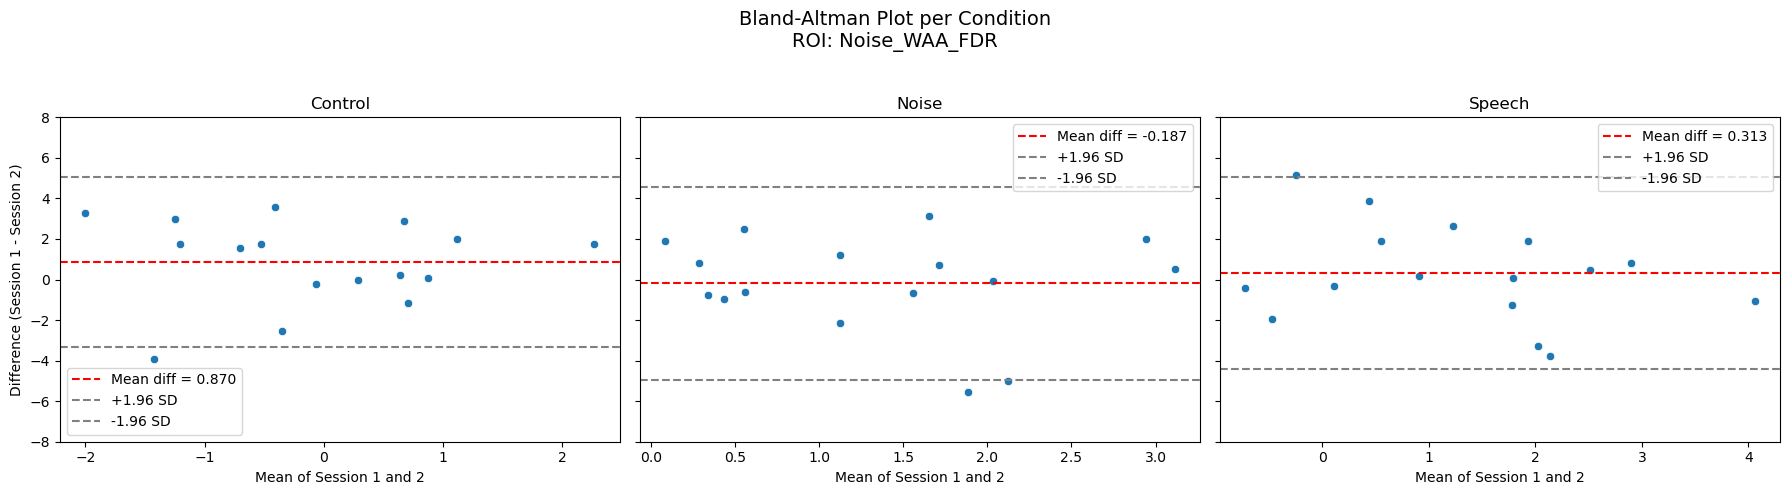

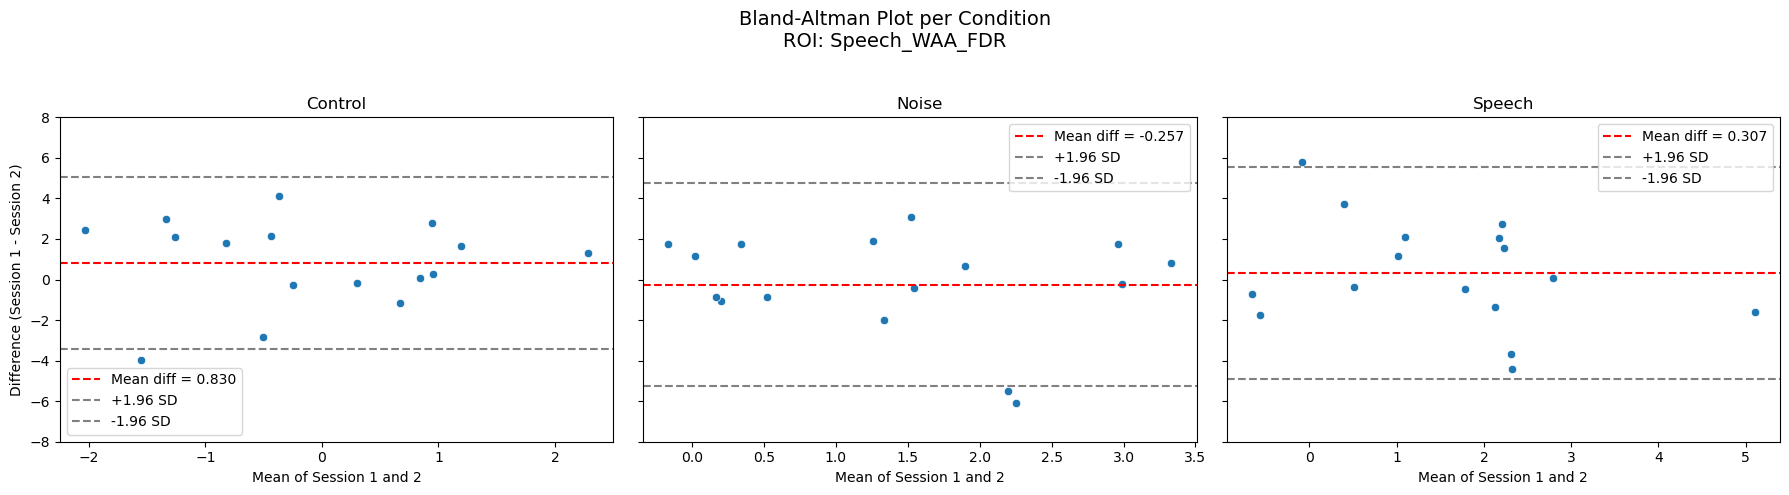

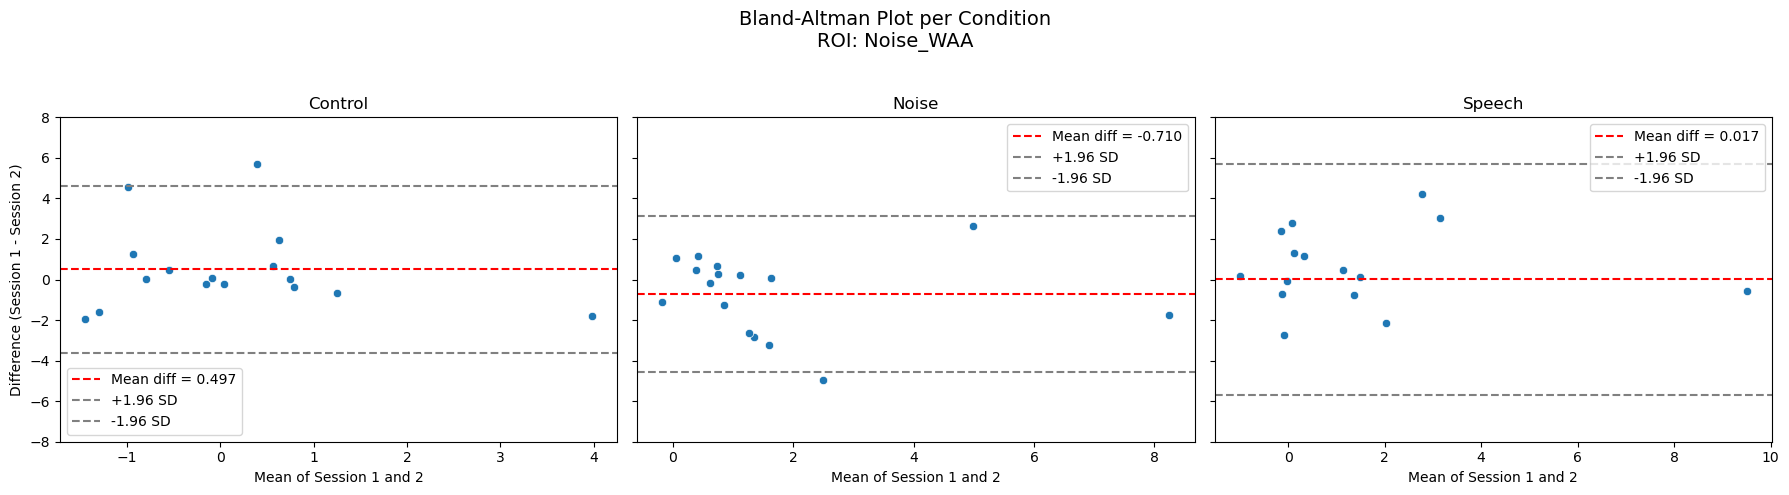

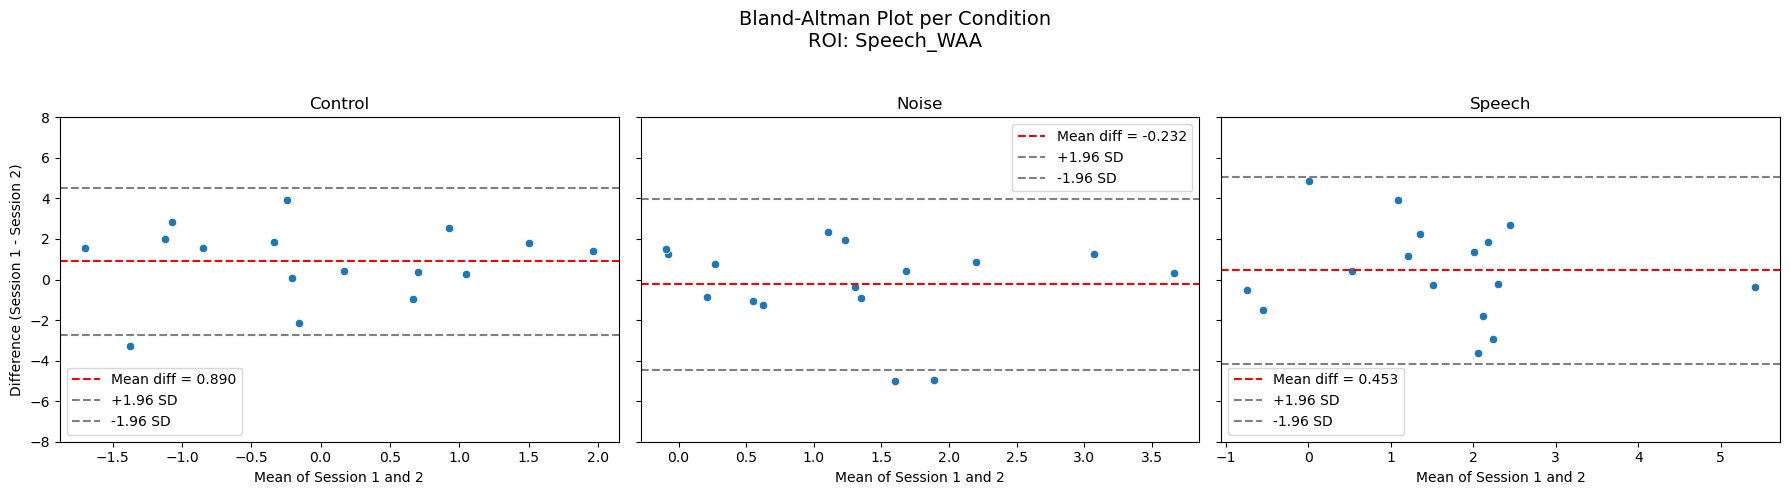

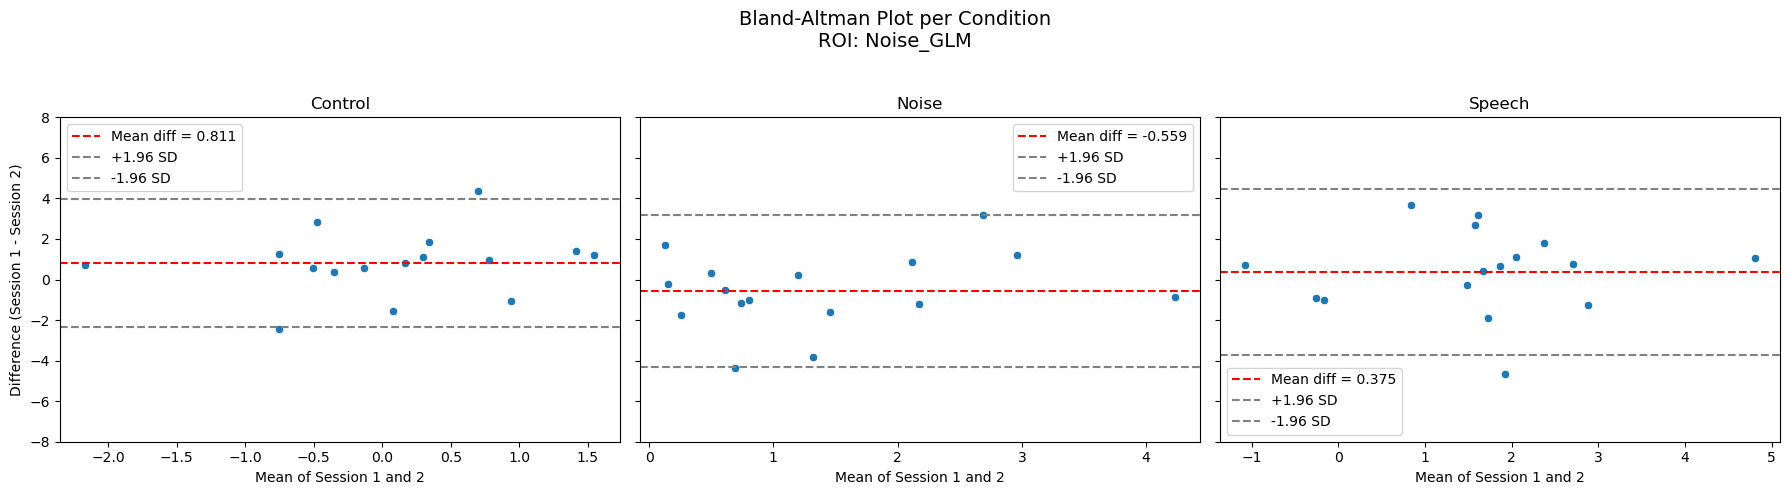

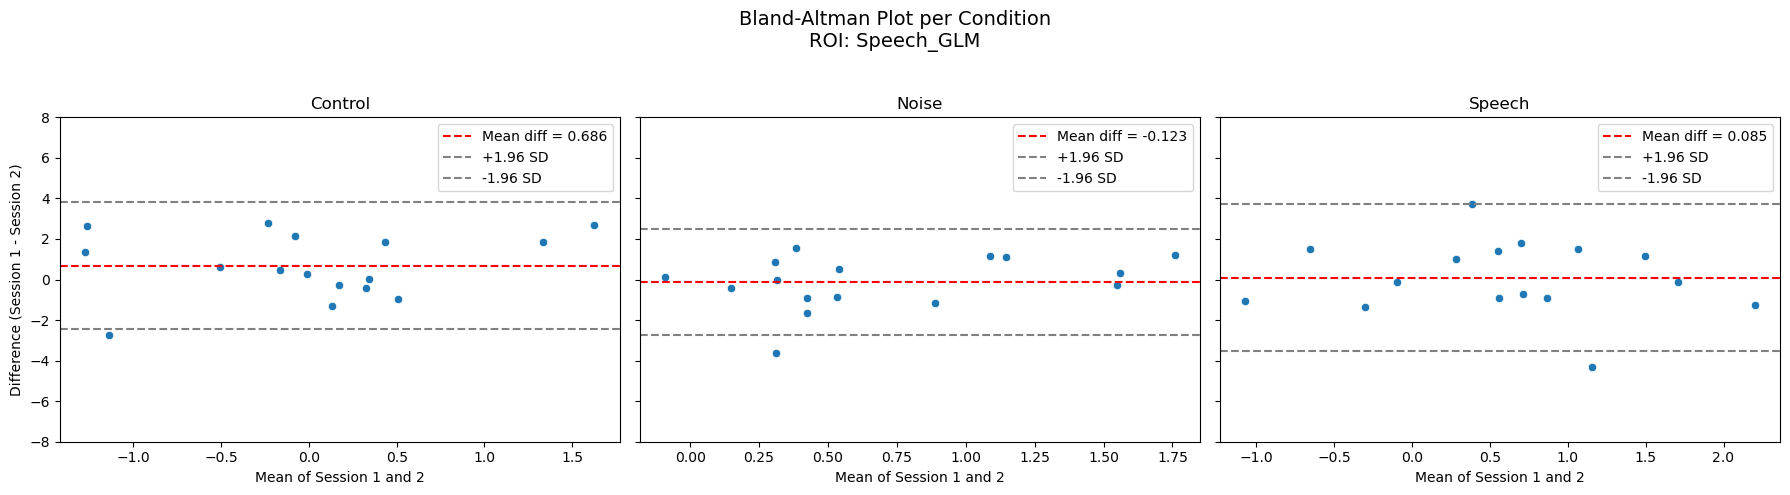

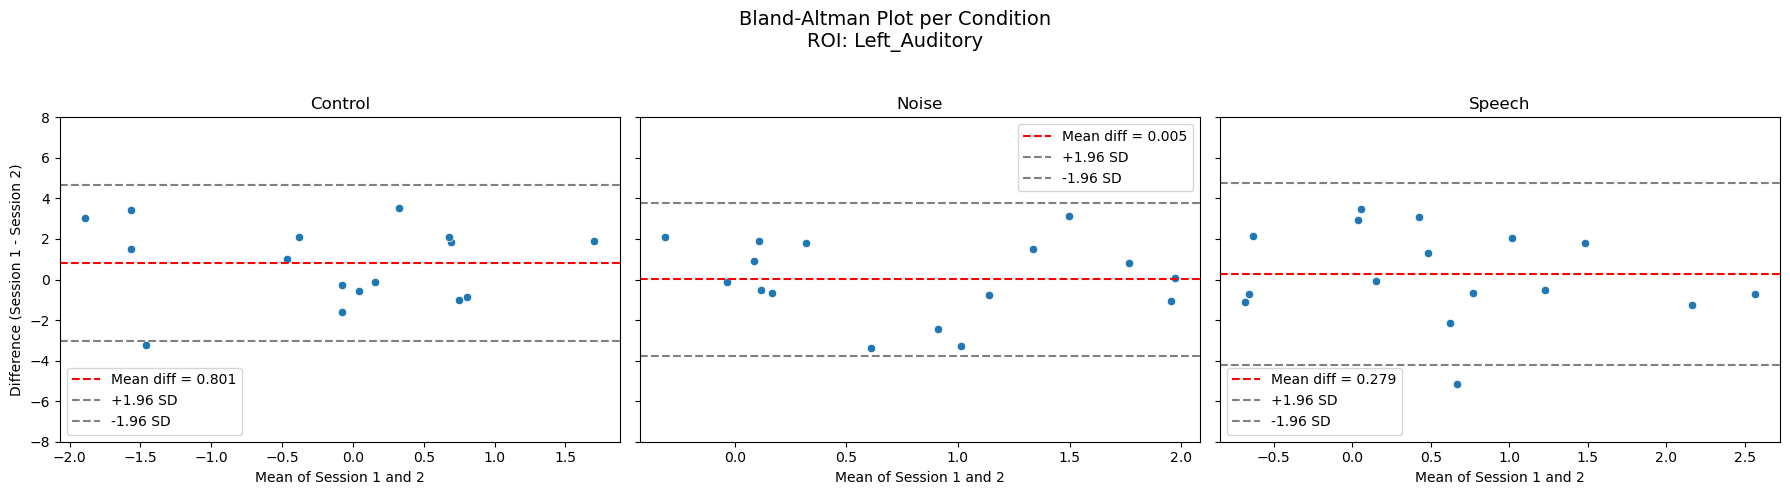

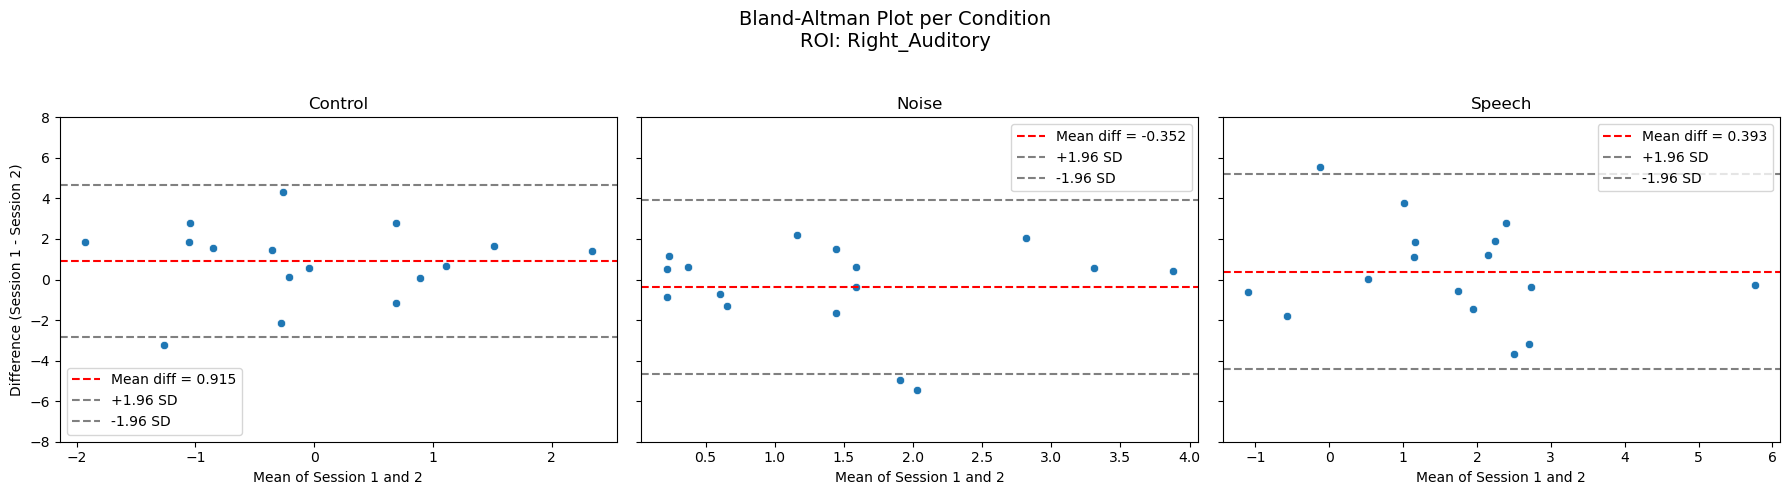

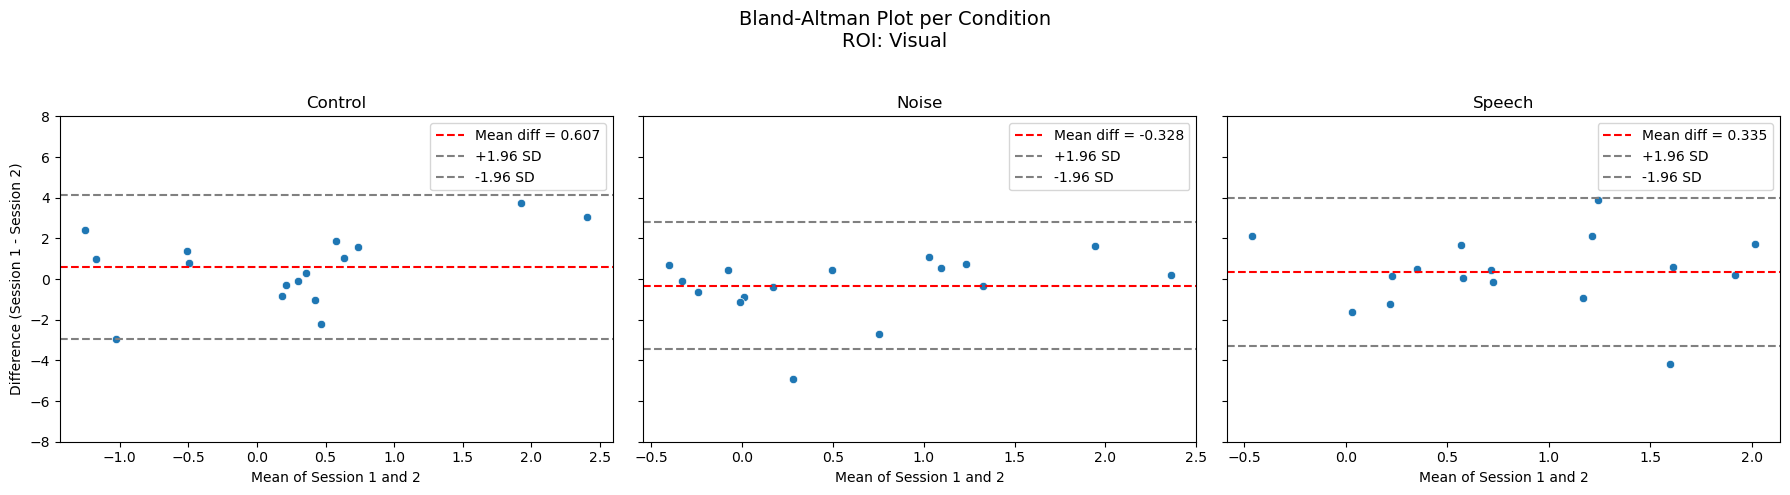

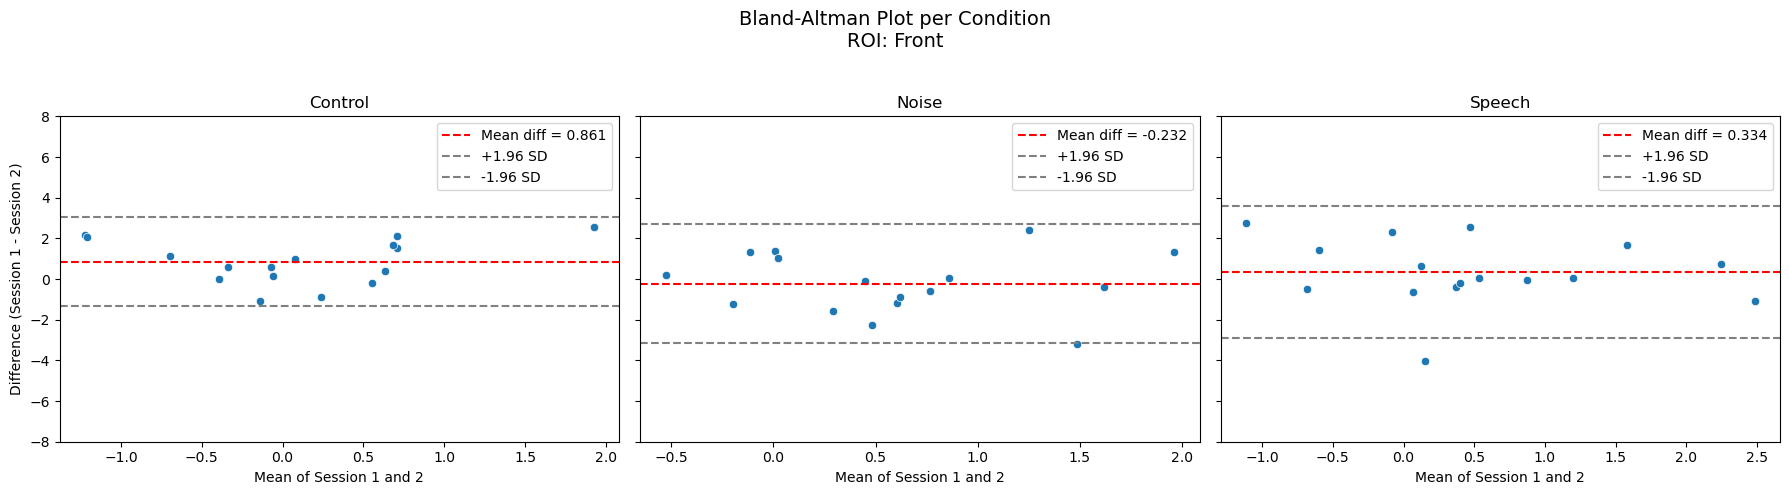

In [261]:
# Get unique experimental conditions
conditions = df_combined["Condition"].unique()
df_combined["Session"] = df_combined["Session"].astype(str).str.zfill(2)

# --- Bland-Altman plots per ROI and condition ---
for roi_name, optodes in rois.items():
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5), sharey=True)
    if len(conditions) == 1:
        axes = [axes]  # Ensure iterable if only one condition

    for ax, condition in zip(axes, conditions):
        # Filter data for current ROI and condition
        subset = df_combined[
            (df_combined["Optode"].isin(optodes)) & 
            (df_combined["Condition"] == condition)
        ]

        # Average over optodes for each subject and session
        mean_vals = subset.groupby(["Subject", "Session"])["Value"].mean().reset_index()

        # Pivot so each subject has session 01 and 02 as columns
        pivot = mean_vals.pivot(index="Subject", columns="Session", values="Value").dropna()

        if pivot.shape[0] < 2:
            ax.set_title(f'{condition}\nNot enough data')
            ax.axis('off')
            continue

        # Bland-Altman calculations
        session1 = pivot["01"]
        session2 = pivot["02"]
        avg = (session1 + session2) / 2
        diff = session1 - session2
        mean_diff = diff.mean()
        std_diff = diff.std()

        # Plot
        sns.scatterplot(x=avg, y=diff, ax=ax)
        ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.3f}')
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
        ax.set_title(f'{condition}')
        ax.set_xlabel('Mean of Session 1 and 2')
        if ax == axes[0]:
            ax.set_ylabel('Difference (Session 1 - Session 2)')
            ax.set_ylim(-8, 8)
        else:
            ax.set_ylabel('')
        ax.legend()

    plt.suptitle(f'Bland-Altman Plot per Condition\nROI: {roi_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Interval WAA
I want to plot the mean response for all participants across all their optodes in the same plot

Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 2 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 2 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 0

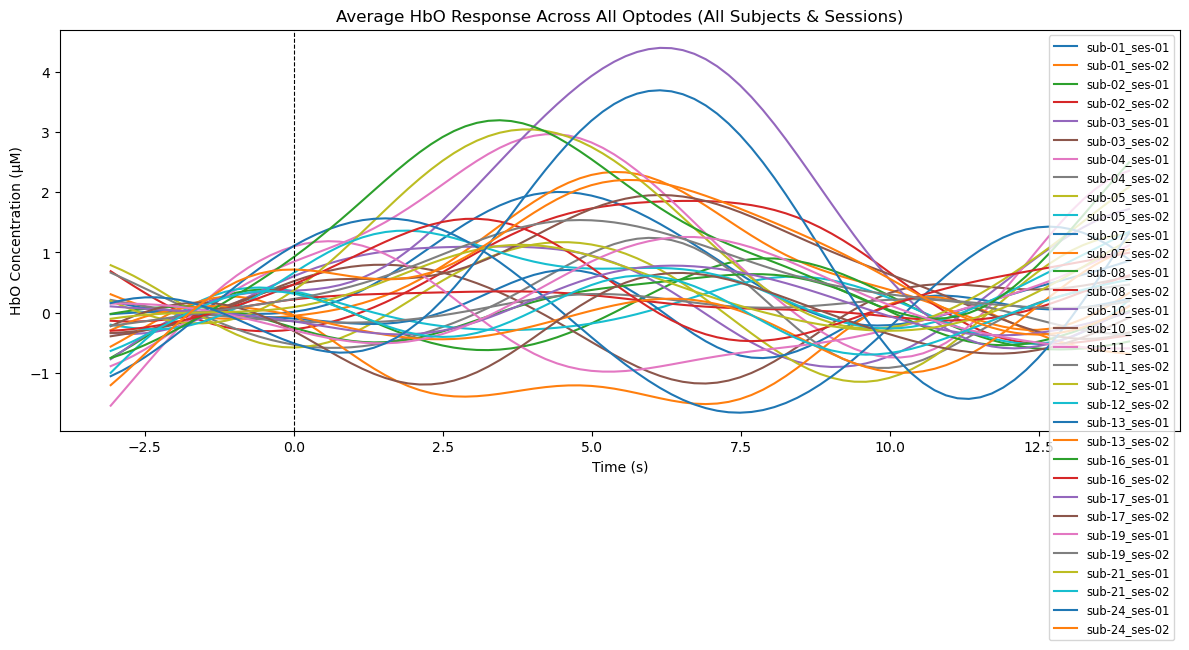

In [81]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
from mne_bids import BIDSPath

bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

print("Detected subjects:", subject_list)
id = 0

all_data = pd.DataFrame()

# === For plotting ===
plt.figure(figsize=(12, 6))

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(
            bids_path, z_thresh=2, stats_df=stats_df
        )

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

        # === Plot average across all optodes and epochs (HbO) ===
        try:
            evoked_all = epochs_cleaned.average()
            evoked_hbo = deepcopy(evoked_all).pick("hbo")
            mean_signal = evoked_hbo.data.mean(axis=0) * 1e6  # average across channels, convert to µM
            times = evoked_hbo.times

            label = f"sub-{sub}_ses-{ses:02d}"
            plt.plot(times, mean_signal, label=label)

        except Exception as e:
            print(f"❌ Failed to plot average for sub-{sub} ses-{ses:02d}: {e}")

        # === Continue with your existing per-condition ROI extraction ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "all_optodes": epochs_cleaned.info["ch_names"]
        }

        """ df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])
        id += 1

        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()
            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                if not valid_optodes:
                    print(f"⚠️ No valid optodes for ROI '{roi_name}' in Subject {sub}. Skipping this ROI.")
                    continue

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=5, tmax=7.0).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "ROI": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )

                    except Exception as e:
                        print(f"❌ Failed to process ROI '{roi_name}' with error: {e}")

        all_data = pd.concat([all_data, df], ignore_index=True)
 """
# === Finalize and show the plot ===
plt.title("Average HbO Response Across All Optodes (All Subjects & Sessions)")
plt.xlabel("Time (s)")
plt.ylabel("HbO Concentration (µM)")
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.legend(loc="upper right", fontsize="small")
plt.tight_layout()
plt.show()


Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 2 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 2 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 0

C:\Users\sarab\AppData\Local\Temp\ipykernel_35072\4236259739.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



📈 Peak HbO values per condition, subject, and session:
   Subject Session Condition  PeakValue  PeakTime
0       01      01   Control   0.239202    -1.920
1       01      01     Noise   3.997562     4.224
2       01      01    Speech   4.170720     4.032
3       01      02   Control   1.600645     6.144
4       01      02     Noise   2.810868     5.184
..     ...     ...       ...        ...       ...
91      24      01     Noise   3.406290     6.336
92      24      01    Speech   5.347762     5.952
93      24      02   Control   0.956524    10.176
94      24      02     Noise   3.626378     5.568
95      24      02    Speech   5.064144     5.184

[96 rows x 5 columns]


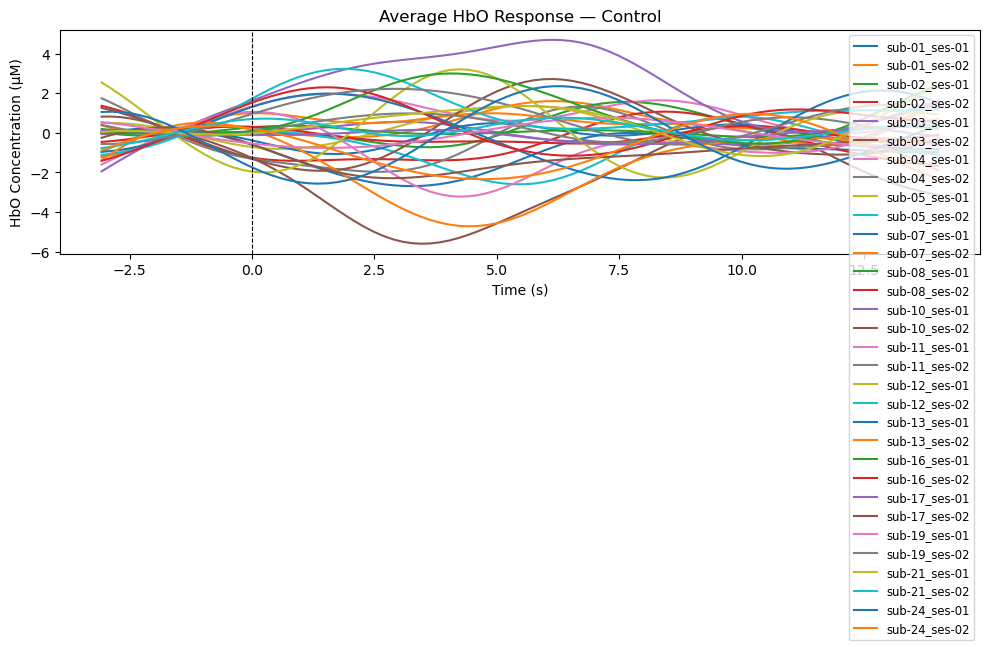

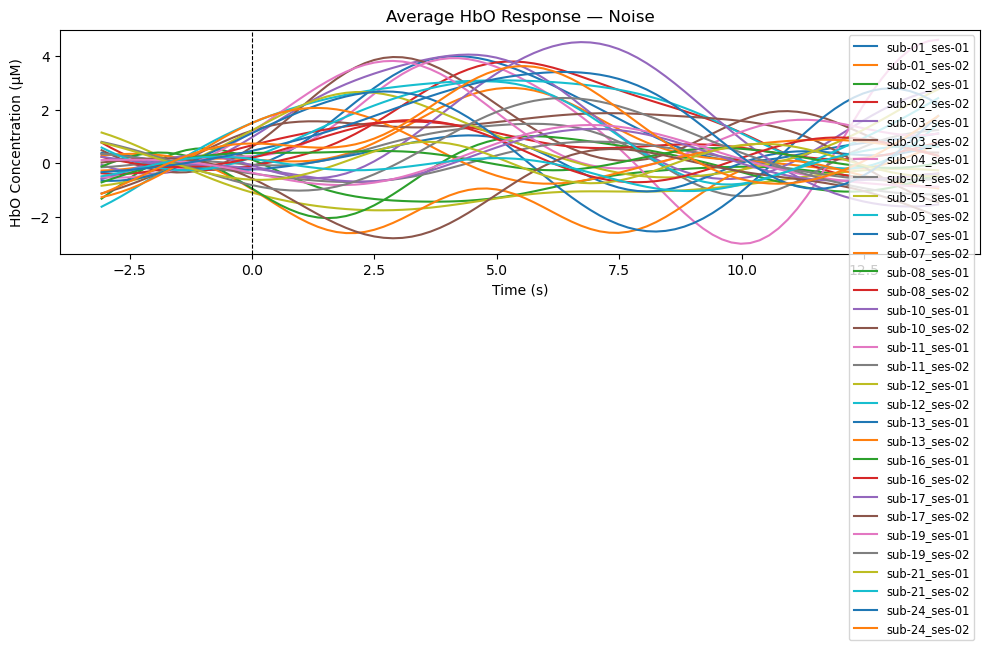

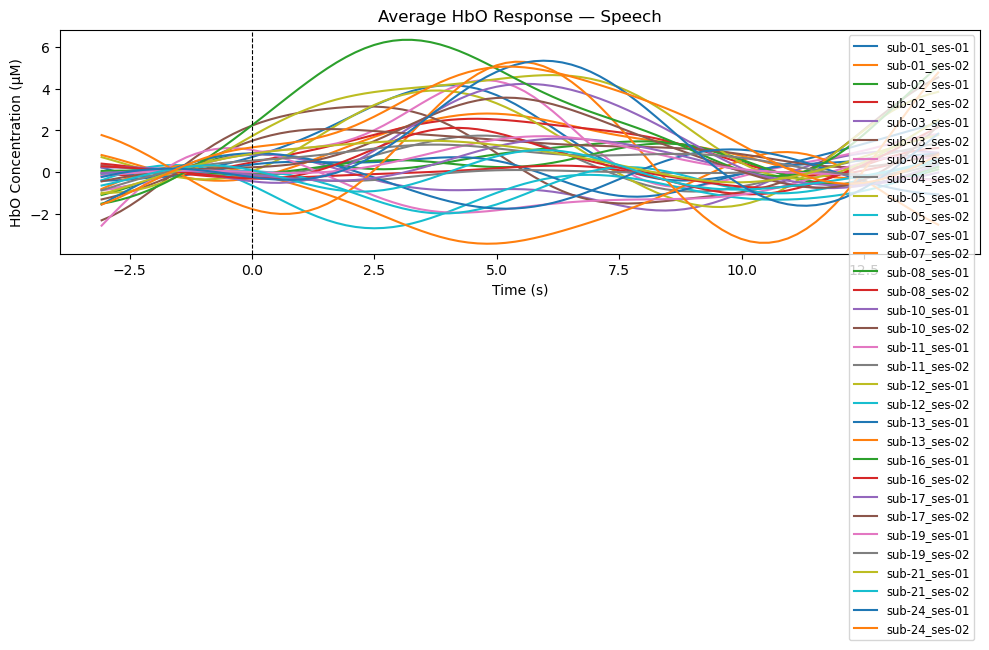

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
from mne_bids import BIDSPath

# Define root of your BIDS dataset
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

print("Detected subjects:", subject_list)
id = 0

all_data = pd.DataFrame()
df_peaks_all = pd.DataFrame(columns=["Subject", "Session", "Condition", "PeakValue", "PeakTime"])

# === Plot setup: One figure per condition ===
figures = {}
for cond in ["Control", "Noise", "Speech"]:
    fig, ax = plt.subplots(figsize=(10, 5))
    figures[cond] = (fig, ax)

# === Loop through subjects and sessions ===
for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Call your preprocessing function here
        epochs_cleaned, event_dict = full_preprocessing_individual(
            bids_path, z_thresh=2, stats_df=stats_df
        )

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

        # === Plot average evoked HbO response per condition and extract peaks ===
        for condition_name in ["Control", "Noise", "Speech"]:
            try:
                evoked = epochs_cleaned[condition_name].average()
                evoked_hbo = deepcopy(evoked).pick("hbo")
                mean_signal = evoked_hbo.data.mean(axis=0) * 1e6  # µM
                times = evoked_hbo.times

                # Plot
                label = f"sub-{sub}_ses-{ses:02d}"
                fig, ax = figures[condition_name]
                ax.plot(times, mean_signal, label=label)

                # Compute peak
                peak_idx = mean_signal.argmax()
                peak_val = mean_signal[peak_idx]
                peak_time = times[peak_idx]

                # Store in peak df
                df_peaks_all = pd.concat(
                    [
                        df_peaks_all,
                        pd.DataFrame(
                            {
                                "Subject": [sub],
                                "Session": [f"{ses:02d}"],
                                "Condition": [condition_name],
                                "PeakValue": [peak_val],
                                "PeakTime": [peak_time],
                            }
                        ),
                    ],
                    ignore_index=True,
                )

            except Exception as e:
                print(f"❌ Failed processing {condition_name} for sub-{sub}, ses-{ses:02d}: {e}")

        # === Your original ROI value extraction continues here ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "all_optodes": epochs_cleaned.info["ch_names"]
        }

        df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])
        id += 1

        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()
            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                if not valid_optodes:
                    print(f"⚠️ No valid optodes for ROI '{roi_name}' in Subject {sub}. Skipping this ROI.")
                    continue

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=5, tmax=7.0).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "ROI": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )

                    except Exception as e:
                        print(f"❌ Failed to process ROI '{roi_name}' with error: {e}")

        all_data = pd.concat([all_data, df], ignore_index=True)

# === Finalize and show plots ===
for condition_name, (fig, ax) in figures.items():
    ax.set_title(f"Average HbO Response — {condition_name}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("HbO Concentration (µM)")
    ax.axvline(0, color="k", linestyle="--", linewidth=0.8)
    ax.legend(fontsize="small", loc="upper right")
    fig.tight_layout()
    fig.show()

# === Final peak summary ===
print("\n📈 Peak HbO values per condition, subject, and session:")
print(df_peaks_all)


Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

C:\Users\sarab\AppData\Local\Temp\ipykernel_35072\1975957802.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


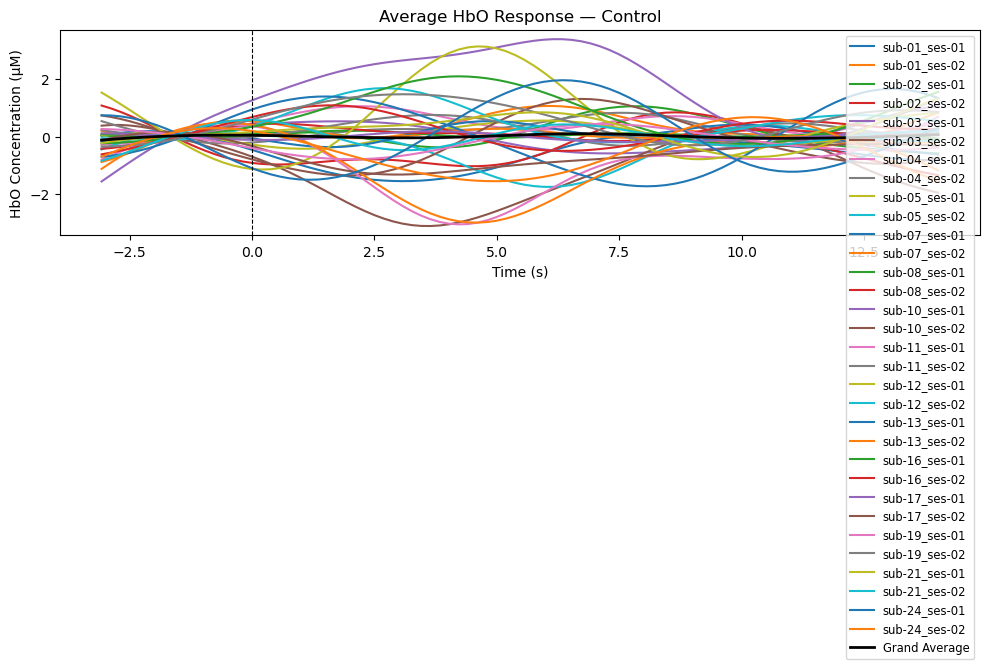

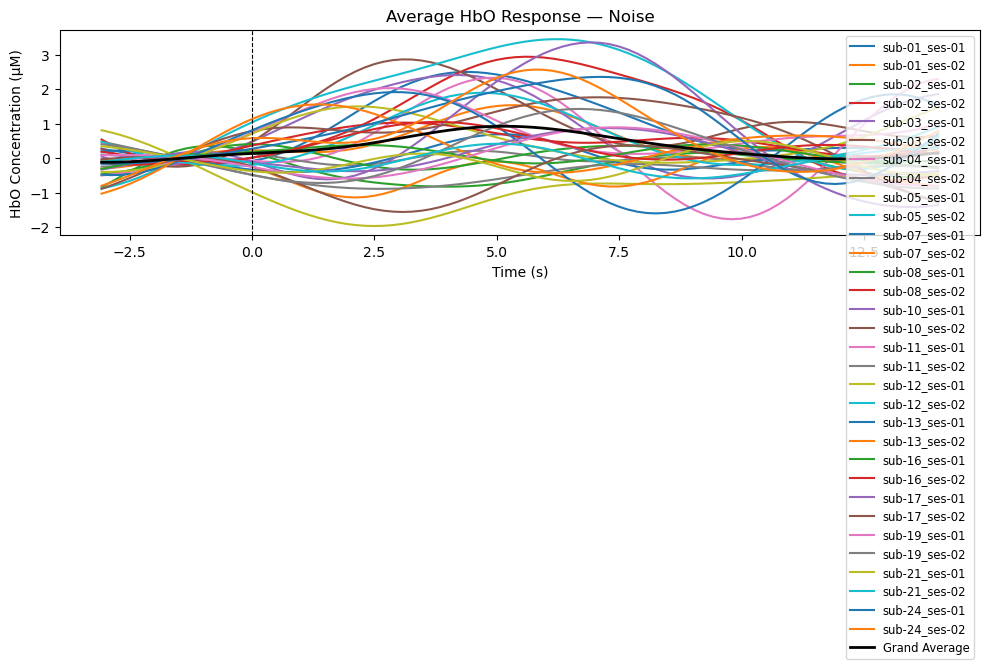

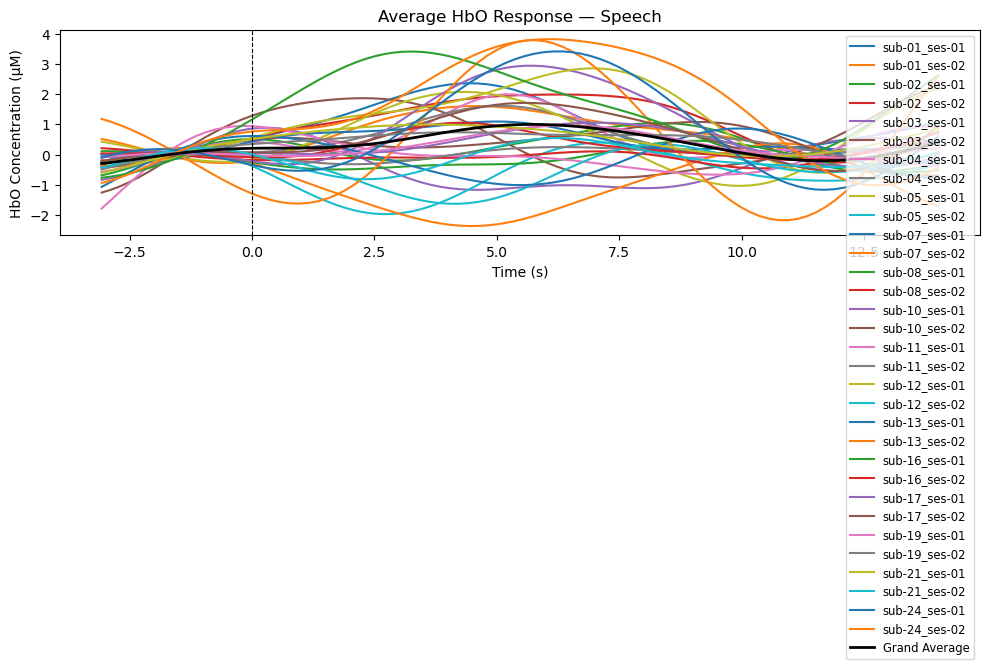

In [160]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
from mne_bids import BIDSPath

# Define root of your BIDS dataset
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

print("Detected subjects:", subject_list)
id = 0

all_data = pd.DataFrame()
df_peaks_all = pd.DataFrame(columns=["Subject", "Session", "Condition", "PeakValue", "PeakTime"])
df_grand_peaks = pd.DataFrame(columns=["Condition", "GrandPeakValue", "GrandPeakTime"])

# === Plot setup: One figure per condition ===
figures = {}
for cond in ["Control", "Noise", "Speech"]:
    fig, ax = plt.subplots(figsize=(10, 5))
    figures[cond] = (fig, ax)

# To store all mean signals for grand average per condition
condition_signals = {"Control": [], "Noise": [], "Speech": []}
condition_times = None  # All evoked times should be the same

# === Loop through subjects and sessions ===
for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Call your preprocessing function here
        epochs_cleaned, event_dict = full_preprocessing_individual(
            bids_path, z_thresh=2, stats_df=stats_df
        )

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

        # === Plot average evoked HbO response per condition and extract peaks ===
        for condition_name in ["Control", "Noise", "Speech"]:
            try:
                evoked = epochs_cleaned[condition_name].average()
                evoked_hbo = deepcopy(evoked).pick("hbo")
                mean_signal = evoked_hbo.data.mean(axis=0) * 1e6  # µM
                times = evoked_hbo.times

                # Store for grand average
                condition_signals[condition_name].append(mean_signal)
                if condition_times is None:
                    condition_times = times

                # Plot individual subject/session response
                label = f"sub-{sub}_ses-{ses:02d}"
                fig, ax = figures[condition_name]
                ax.plot(times, mean_signal, label=label)

                # Compute peak
                peak_idx = mean_signal.argmax()
                peak_val = mean_signal[peak_idx]
                peak_time = times[peak_idx]

                # Store in peak df
                df_peaks_all = pd.concat(
                    [
                        df_peaks_all,
                        pd.DataFrame(
                            {
                                "Subject": [sub],
                                "Session": [f"{ses:02d}"],
                                "Condition": [condition_name],
                                "PeakValue": [peak_val],
                                "PeakTime": [peak_time],
                            }
                        ),
                    ],
                    ignore_index=True,
                )

            except Exception as e:
                print(f"❌ Failed processing {condition_name} for sub-{sub}, ses-{ses:02d}: {e}")

# === Add grand average to each condition plot and store peaks ===
for condition_name, (fig, ax) in figures.items():
    if condition_signals[condition_name]:
        signals = np.vstack(condition_signals[condition_name])
        mean_across_subjects = signals.mean(axis=0)
        ax.plot(
            condition_times,
            mean_across_subjects,
            color="black",
            linewidth=2,
            label="Grand Average"
        )

        # Compute grand peak
        grand_peak_idx = mean_across_subjects.argmax()
        grand_peak_val = mean_across_subjects[grand_peak_idx]
        grand_peak_time = condition_times[grand_peak_idx]
        
        
        

        # Save to df
        df_grand_peaks = pd.concat(
            [
                df_grand_peaks,
                pd.DataFrame(
                    {
                        "Condition": [condition_name],
                        "GrandPeakValue": [grand_peak_val],
                        "GrandPeakTime": [grand_peak_time],
                    }
                ),
            ],
            ignore_index=True,
        )

        ax.set_title(f"Average HbO Response — {condition_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("HbO Concentration (µM)")
        ax.axvline(0, color="k", linestyle="--", linewidth=0.8)
        ax.legend(fontsize="small", loc="upper right")
        fig.tight_layout()
        fig.show()

# === Final peak summaries ===
print("\n📈 Peak HbO values per condition, subject, and session:")
print(df_peaks_all)

print("\n🌟 Grand average peak values per condition:")
print(df_grand_peaks)


In [161]:
# === Standard deviation of peak times per condition ===
peak_time_sd = df_peaks_all.groupby("Condition")["PeakTime"].std().reset_index()
peak_time_sd.columns = ["Condition", "PeakTime_SD"]

print("\n📊 Standard deviation of peak times per condition:")
print(peak_time_sd)



📊 Standard deviation of peak times per condition:
  Condition  PeakTime_SD
0   Control     5.334698
1     Noise     3.688824
2    Speech     3.341674


In [162]:
import numpy as np

def find_peak_interval(df_peaks_all, coverage=0.8):
    intervals = {}

    for condition in df_peaks_all["Condition"].unique():
        times = df_peaks_all[df_peaks_all["Condition"] == condition]["PeakTime"].values
        times = np.sort(times)
        n_total = len(times)
        n_target = int(np.ceil(coverage * n_total))

        # Slide a window of n_target points and find the smallest range
        min_width = np.inf
        best_start = best_end = None

        for i in range(n_total - n_target + 1):
            window_start = times[i]
            window_end = times[i + n_target - 1]
            width = window_end - window_start

            if width < min_width:
                min_width = width
                best_start = window_start
                best_end = window_end

        intervals[condition] = {
            "Start": best_start,
            "End": best_end,
            "Width": min_width,
            "Coverage": f"{coverage * 100:.0f}%",
            "IncludedPeaks": n_target,
            "TotalPeaks": n_total,
        }

    return pd.DataFrame.from_dict(intervals, orient="index")

# === Example usage:
interval_df = find_peak_interval(df_peaks_all, coverage=0.5)
print(interval_df)


         Start    End  Width Coverage  IncludedPeaks  TotalPeaks
Control  2.112  7.872  5.760      50%             16          32
Noise    4.224  7.488  3.264      50%             16          32
Speech   4.224  6.528  2.304      50%             16          32


In [163]:
def find_fixed_window_peak_coverage(df_peaks_all, window_width=2.0):
    results = {}

    for condition in df_peaks_all["Condition"].unique():
        times = np.sort(df_peaks_all[df_peaks_all["Condition"] == condition]["PeakTime"].values)
        n_total = len(times)

        max_count = 0
        best_start = best_end = None

        for i in range(n_total):
            start = times[i]
            end = start + window_width
            count = np.sum((times >= start) & (times <= end))

            if count > max_count:
                max_count = count
                best_start = start
                best_end = end

        results[condition] = {
            "Start": round(best_start, 3),
            "End": round(best_end, 3),
            "Width": window_width,
            "PeaksInWindow": max_count,
            "TotalPeaks": n_total,
            "Coverage": f"{(max_count / n_total * 100):.1f}%",
        }

    return pd.DataFrame.from_dict(results, orient="index")

interval_df_2 = find_fixed_window_peak_coverage(df_peaks_all, window_width=2)
print(interval_df_2)

         Start    End  Width  PeaksInWindow  TotalPeaks Coverage
Control  5.952  7.952      2              8          32    25.0%
Noise    3.840  5.840      2             10          32    31.2%
Speech   4.416  6.416      2             13          32    40.6%


In [187]:
def count_peaks_in_interval(df_peaks_all, tmin, tmax):
    results = {}

    for condition in df_peaks_all["Condition"].unique():
        condition_df = df_peaks_all[df_peaks_all["Condition"] == condition]
        total_peaks = len(condition_df)
        peaks_in_interval = condition_df[
            (condition_df["PeakTime"] >= tmin) & (condition_df["PeakTime"] <= tmax)
        ]
        count = len(peaks_in_interval)
        coverage = (count / total_peaks) * 100 if total_peaks > 0 else 0

        results[condition] = {
            "PeaksInInterval": count,
            "TotalPeaks": total_peaks,
            "Coverage (%)": round(coverage, 1),
            "IntervalStart": tmin,
            "IntervalEnd": tmax,
        }

    return pd.DataFrame.from_dict(results, orient="index")

tmin = 4.25
tmax = 6.75
coverage_df = count_peaks_in_interval(df_peaks_all, tmin, tmax)
print(coverage_df)



         PeaksInInterval  TotalPeaks  Coverage (%)  IntervalStart  IntervalEnd
Control                7          32          21.9           4.25         6.75
Noise                 10          32          31.2           4.25         6.75
Speech                14          32          43.8           4.25         6.75
